In [213]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import xmltodict
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

def parse(filename):
    # Load the XML file
    with open(filename) as file:
        xml_data = file.read()

    # Convert XML to dictionary
    data_dict = xmltodict.parse(xml_data)
    doc = data_dict["Document"]
    data = []
    pandas_data = {}
    for dataset in doc["DataSet"]:
        if "DataColumn" not in dataset.keys():
            continue
        data_object = {
            "name": dataset["DataSetName"],
            "columns": []
        }
        for datacolumn in dataset["DataColumn"]:
            if "ColumnCells" in datacolumn.keys():
                data_object["columns"].append({
                    "name": datacolumn["DataObjectName"],
                    "value": datacolumn["ColumnCells"].split("\n")
                })
        p = pd.DataFrame.from_dict({x["name"]:x["value"] for x in data_object["columns"]})
        p["Time"] = p["Time"].astype(float)
        p["GateState"] = p["GateState"].astype(int)
        pandas_data[dataset["DataSetName"]] = p
        data.append(data_object)ja
    return pandas_data

In [91]:
pddata = parse("brez_koles.cmbl") | parse("prazen_primer.cmbl") | parse("s_kolesi.cmbl")

### Pomoč pri poimenovanju meritev

|                       | Utež | Meritev 1                    | Meritev 2                    | Meritev 3                    |
|-----------------------|------|------------------------------|------------------------------|------------------------------|
| Brez uteži            | /    | Brez uteži                   |                              |                              |
| Prazno kolo           | 50g  | utež 50g meritev 1           | utež 50g meritev 2           | utež 50g 3 meritev           |
| Prazno kolo           | 100g | utre 100g 1 meritev          | utež 100g 2 meritev          | utež 100g 3 meritev          |
| Togo vpeti kolesi     | 50g  | 50 g togo vpeta kolesa 1     | 50g togo vpeta kolesa 2      | 50g togo vpeta kolesa 3      |
| Togo vpeti kolesi     | 100g | 100g togo vpeta kolesa 1     | 100g togo vpeta utež 2       | Latest(!)                    |
| Gibljivo vpeti kolesi | 50g  | 50 g gibljivo vpeta kolesa 1 | 50g gibljivo vpeta kolesa 2  | 50g gibljivo vpeta utež      |
| Gibljivo vpeti kolesi | 100g | 100g gibljivo vpeta kolesa 1 | 100g gibljivo vpeta kolesa 2 | 100g gibljivo vpeta kolesa 3 |

(!) - meriteve, za katere nisem prepričan da so nujno prave, a glede na tabelo jih lahko uvrstim na trenutno mesto

In [255]:
pddata = {k:v[v["GateState"] != 0].reset_index(drop=True) for k, v in pddata.items()}

In [102]:
def add_distance(x):
    x["Distance"] = x.index.values*math.pi/4
    return x
pddata = {k:add_distance(v) for k, v in pddata.items()}

In [105]:
def add_velocity(x):
    x["Velocity"] = x["Distance"].diff() / x["Time"].diff()
    return x
pddata = {k:add_velocity(v) for k, v in pddata.items()}

In [109]:
def add_accel(x):
    x["Acceleration"] = x["Velocity"].diff() / x["Time"].diff()
    return x
pddata = {k:add_accel(v) for k, v in pddata.items()}

<Axes: xlabel='Time', ylabel='Distance'>

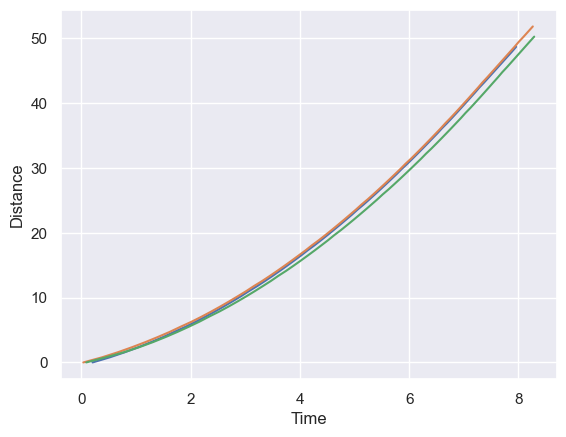

In [233]:
sns.set_theme()
sns.lineplot(x="Time", y="Distance", data = pddata["100g gibljivo vpeta kolesa 1"])
sns.lineplot(x="Time", y="Distance", data = pddata["100g gibljivo vpeta kolesa 2"])
sns.lineplot(x="Time", y="Distance", data = pddata["100g gibljivo vpeta kolesa 3"])

<Axes: xlabel='Time', ylabel='Velocity'>

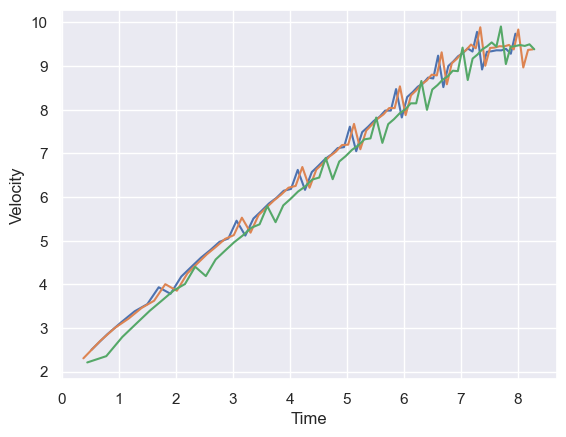

In [234]:
sns.lineplot(x="Time", y="Velocity", data = pddata["100g gibljivo vpeta kolesa 1"])
sns.lineplot(x="Time", y="Velocity", data = pddata["100g gibljivo vpeta kolesa 2"])
sns.lineplot(x="Time", y="Velocity", data = pddata["100g gibljivo vpeta kolesa 3"])

<Axes: xlabel='Time', ylabel='Acceleration'>

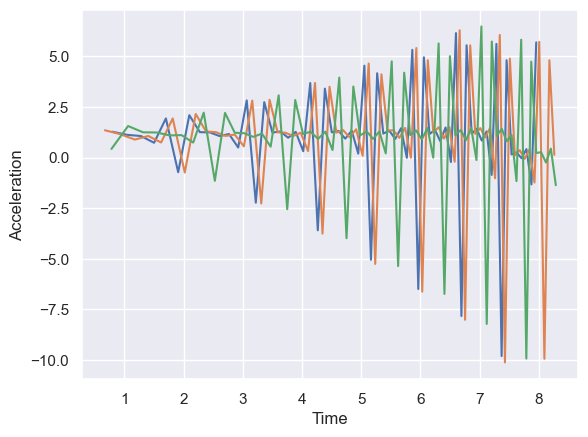

In [235]:
sns.set_theme()
sns.lineplot(x="Time", y="Acceleration", data = pddata["100g gibljivo vpeta kolesa 1"])
sns.lineplot(x="Time", y="Acceleration", data = pddata["100g gibljivo vpeta kolesa 2"])
sns.lineplot(x="Time", y="Acceleration", data = pddata["100g gibljivo vpeta kolesa 3"])

In [236]:
def tripleGraph(dfs):
    for i, df in enumerate(dfs):
        df["Meritev"] = f"Meritev {i+1}"
    cmb = pd.concat(dfs)
    cmb = cmb[~cmb["Velocity"].isnull()]
    cmb = cmb[~cmb["Acceleration"].isnull()]
    fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
    fig.tight_layout(pad=3.0)
    axes[0].set(xlabel="Čas [s]", ylabel="Kotna razdalja [rad]")
    axes[1].set(xlabel="Čas [s]", ylabel="Kotna hitrost [$s^{-1}$]")
    axes[2].set(xlabel="Čas [s]", ylabel="Kotni pospešek [$s^{-2}$]")
    sns.lineplot(ax=axes[0], x="Time", y="Distance", data=cmb, hue="Meritev")
    sns.scatterplot(ax=axes[1], x="Time", y="Velocity", data=cmb, hue="Meritev")
    sns.scatterplot(ax=axes[2], x="Time", y="Acceleration", data=cmb, hue="Meritev")

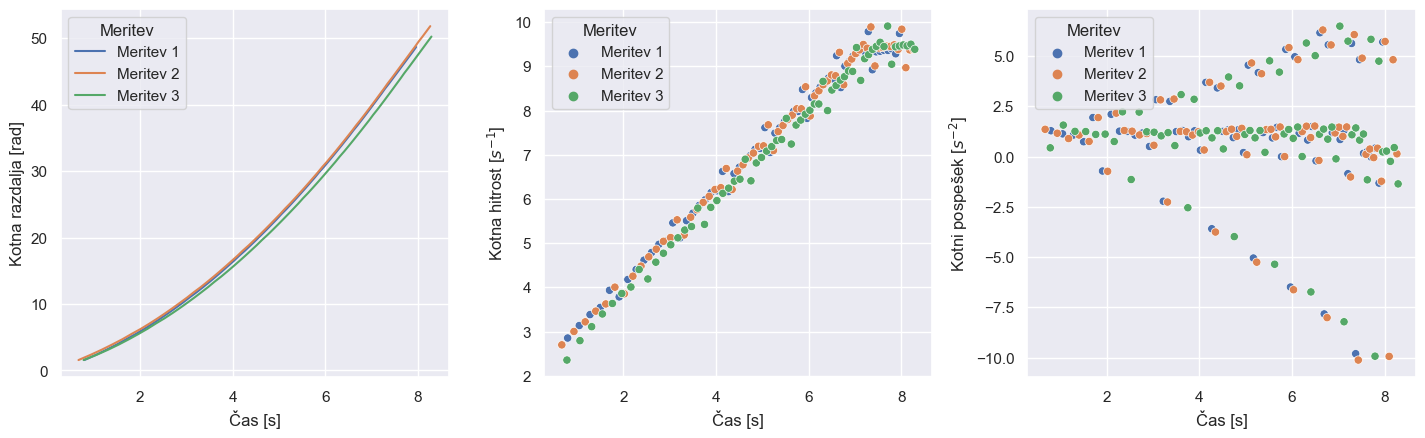

In [237]:
tripleGraph([pddata["100g gibljivo vpeta kolesa 1"], pddata["100g gibljivo vpeta kolesa 2"], pddata["100g gibljivo vpeta kolesa 3"]])

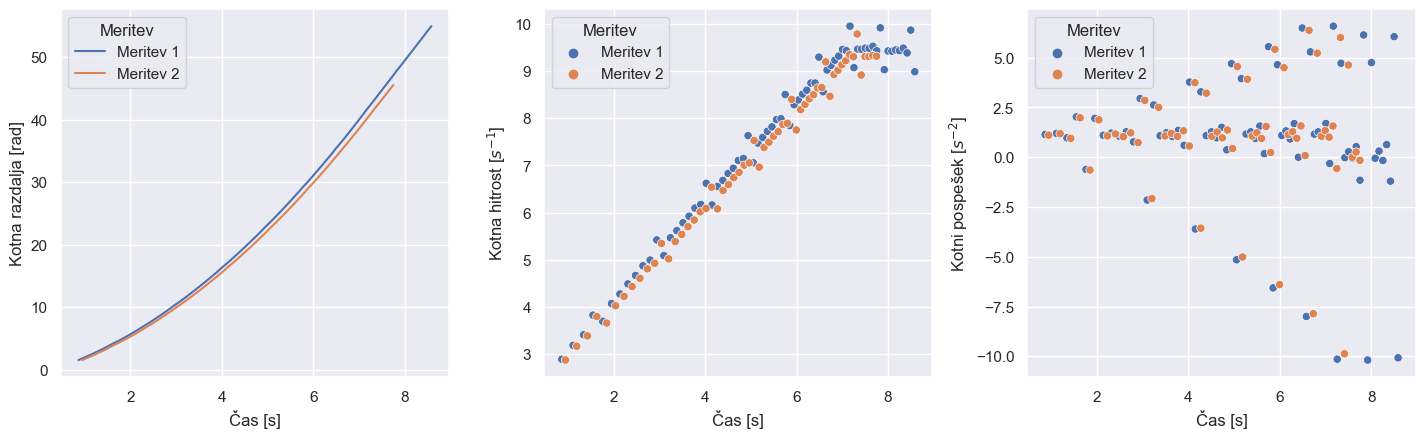

In [238]:
tripleGraph([pddata["100g togo vpeta kolesa 1"], pddata["100g togo vpeta utež 2"]])

In [205]:
def getCoef(p):
    p = p[p["Time"].between(2, 6)]
    model = LinearRegression()
    model.fit(p["Time"].to_numpy().reshape(-1, 1), p["Velocity"].to_numpy())
    r_sq = model.score(p["Time"].to_numpy().reshape(-1, 1), p["Velocity"].to_numpy())
    return (model.coef_, r_sq)

acc = {k:getCoef(v) for k, v in pddata.items()}

In [209]:
acc_table = [["Meritev", "Pospešek", "r^2"]]
acc_table += [[k, v[0], v[1]] for k, v in acc.items()]

In [210]:
from tabulate import tabulate

print(tabulate(acc_table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════════════════╤════════════╤══════════╕
│ Meritev                      │   Pospešek │      r^2 │
╞══════════════════════════════╪════════════╪══════════╡
│ utež 100g 3 meritev          │  1.64338   │ 0.975561 │
├──────────────────────────────┼────────────┼──────────┤
│ Brez uteži                   │ -0.0695187 │ 0.236477 │
├──────────────────────────────┼────────────┼──────────┤
│ utež 50g meritev 1           │  0.84261   │ 0.982287 │
├──────────────────────────────┼────────────┼──────────┤
│ utež 50g meritev 2           │  0.848561  │ 0.977999 │
├──────────────────────────────┼────────────┼──────────┤
│ utež 50g 3 meritev           │  0.859698  │ 0.979509 │
├──────────────────────────────┼────────────┼──────────┤
│ utrež 100g 1 meritev         │  1.52505   │ 0.959738 │
├──────────────────────────────┼────────────┼──────────┤
│ utež 100g 2 meritev          │  1.5575    │ 0.973413 │
├──────────────────────────────┼────────────┼──────────┤
│ Latest                       

### Rezultati meritev pospeška

|                       | Utež | Meritev 1                    | Meritev 2                    | Meritev 3                    |
|-----------------------|------|------------------------------|------------------------------|------------------------------|
| Brez uteži            | /    | -0.0695187                   |                              |                              |
| Prazno kolo           | 50g  | 0.84261                      | 0.848561                     | 0.859698                     |
| Prazno kolo           | 100g | 1.52505                      | 1.5575                       | 1.64338                      |
| Togo vpeti kolesi     | 50g  | 0.524318                     | 0.55585                      | 0.546274                     |
| Togo vpeti kolesi     | 100g | 1.0496                       | 1.02797                      |                              |
| Gibljivo vpeti kolesi | 50g  | 0.558036                     | 0.520133                     | 0.515175                     |
| Gibljivo vpeti kolesi | 100g | 1.02957                      | 1.06483                      | 1.02337                      |


Izmerjena vrednost: r_0 = 21mm

In [211]:
transformed = [
    {
        "name": "Prazno kolo",
        "mass": 0.050,
        "acc": [
            0.84261, 0.848561, 0.859698
        ]
    },
    {
        "name": "Prazno kolo",
        "mass": 0.100,
        "acc": [
            1.52505, 1.5575, 1.64338
        ]
    },
    {
        "name": "Togo vpeti kolesi",
        "mass": 0.050,
        "acc": [
            0.524318, 0.55585, 0.546274
        ]
    },
    {
        "name": "Togo vpeti kolesi",
        "mass": 0.100,
        "acc": [
            1.0496, 1.02797
        ]
    },
    {
        "name": "Gibljivo vpeti kolesi",
        "mass": 0.050,
        "acc": [
            0.558036, 0.520133, 0.515175
        ]
    },
    {
        "name": "Togo vpeti kolesi",
        "mass": 0.100,
        "acc": [
            1.02957, 1.06483, 1.02337
        ]
    },
]

In [244]:
r_0 = 0.021
g = 9.81
for k, i in enumerate(transformed):
    transformed[k]["J"] = i["mass"]*(r_0*g - r_0**2 * np.array(i["acc"]))/np.array(i["acc"])

In [245]:
def meanWithError(x):
    avg = sum(x)/len(x)
    abs_err = max(abs(i-avg) for i in x)
    return avg, abs_err


In [263]:
meanJP, err = meanWithError(np.concatenate((transformed[0]["J"],transformed[1]["J"])))
print(f"J za prazen primer = {round(meanJP,4)} ± {round(err, 5)} kgm^2")

J za prazen primer = 0.0126 ± 0.00089 kgm^2


In [264]:
meanJT, err = meanWithError(np.concatenate((transformed[2]["J"],transformed[3]["J"])))
print(f"J za togo vpeti kolesi = {round(meanJT,4)} ± {round(err, 5)} kgm^2")

J za togo vpeti kolesi = 0.0193 ± 0.0008 kgm^2


In [265]:
meanJV, err = meanWithError(np.concatenate((transformed[4]["J"],transformed[5]["J"])))
print(f"J za gibljivo vpeti kolesi = {round(meanJV,4)} ± {round(err, 5)} kgm^2")

J za gibljivo vpeti kolesi = 0.0196 ± 0.00115 kgm^2


In [259]:
#izračun J dodatka
J = 0.5*0.515*0.05**2 + 0.515*0.07**2

## Izračun teoretičnega J


In [268]:
m = 0.514 #kg
R = 0.05 #m
R_p = 0.07 #m

J_k = 0.5*m*R**2 + m*R_p**2

# Ker sta na veliko kolo pripeta 2 mala kolesa, je razlika J enak 2*J_k

print(f"Izračunana razlika J = {round(2*J_k,4)} kgm^2")
r, er = meanWithError([meanJT -meanJP, meanJV - meanJP])
print(f"Dejanska razlika je {round(r, 4)} ± {round(er,5)} kgm^2")

Izračunana razlika J = 0.0063 kgm^2
Dejanska razlika je 0.0069 ± 0.00014 kgm^2
